In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client

In [2]:
%matplotlib notebook

In [3]:
%matplotlib inline

In [5]:
# sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting.letkf_forecasting as lf
import letkf_forecasting.prepare_sat_data as prep
import letkf_forecasting.random_functions as rf
import letkf_forecasting.get_wrf_data as gwd
import letkf_forecasting.interpolate_data as tmh_id

In [6]:
cloudy_month = 6
cloudy_day = 12
clear_month = 6
clear_day = 7

In [7]:
year = 2014
month = cloudy_month
day = cloudy_day
solar_noon = pd.Timestamp('12:30:00')
solar_noon = solar_noon.replace(year=year, month=month, day=day)
print(solar_noon)
step = pd.Timedelta('3h')
start = solar_noon - step
start = (start - pd.Timedelta('30min')).round(freq='1h')
end = solar_noon + step
end = (end + pd.Timedelta('30min')).round(freq='1h')
time_range = pd.date_range(start, end, freq='1h')
time_range = time_range.tz_localize('MST')
print(time_range)

2014-06-12 12:30:00
DatetimeIndex(['2014-06-12 09:00:00-07:00', '2014-06-12 10:00:00-07:00',
               '2014-06-12 11:00:00-07:00', '2014-06-12 12:00:00-07:00',
               '2014-06-12 13:00:00-07:00', '2014-06-12 14:00:00-07:00',
               '2014-06-12 15:00:00-07:00', '2014-06-12 16:00:00-07:00'],
              dtype='datetime64[ns, MST]', freq='H')


In [10]:
wrf_path = '/a2/uaren/{year}/{month:02}/{day:02}/solar_3/wrfsolar_d02_hourly.nc'
wrf_path = wrf_path.format(year=year, month=month, day=day)
print(wrf_path)
save_path = '/home/travis/python_code/letkf_forecasting_other_things/data/'
print(save_path)

/a2/uaren/2014/06/12/solar_3/wrfsolar_d02_hourly.nc
/home/travis/python_code/letkf_forecasting_other_things/data/


In [8]:
importlib.reload(gwd)
gwd.main(time_range=time_range, wrf_path=wrf_path, save_path=save_path)

./data/for_6_12/raw_winds/


In [13]:
this = xr.open_dataset(wrf_path)

In [14]:
this

<xarray.Dataset>
Dimensions:  (Time: 49, bottom_top: 37, south_north: 351, south_north_stag: 352, west_east: 429, west_east_stag: 430)
Coordinates:
    XLAT     (south_north, west_east) float32 30.9118 30.9114 30.911 30.9106 ...
    XLONG    (south_north, west_east) float32 -115.175 -115.156 -115.137 ...
Dimensions without coordinates: Time, bottom_top, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    P        (Time, bottom_top, south_north, west_east) float32 1178.27 ...
    PB       (Time, bottom_top, south_north, west_east) float32 94832.6 ...
    QVAPOR   (Time, bottom_top, south_north, west_east) float32 0.00548004 ...
    SWDDNI   (Time, south_north, west_east) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SWDNB    (Time, south_north, west_east) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SWDNBC   (Time, south_north, west_east) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    T        (Time, bottom_top, south_north, west_east) float32 3.3883 ...
    T2       (Time, south

In [11]:
suffix = '_' + str(month) + '_' + str(day)
file = save_path + 'for' + suffix + '/raw_winds/' + '{var}'
U = pd.read_hdf(file.format(var='U.h5'), 'U')                                                                     
V = pd.read_hdf(file.format(var='V.h5'), 'V')                                                                                                                             
wind_lats = np.load(file.format(var='wind_lats.npy'))                                                                                                                 
wind_lons = np.load(file.format(var='wind_lons.npy'))                                                                                                                 
U_shape = np.load(file.format(var='U_shape.npy'))                                                                                                                   
V_shape = np.load(file.format(var='V_shape.npy'))

In [12]:
U

,0,1,2,3,4,5,6,7,8,9,...,150920,150921,150922,150923,150924,150925,150926,150927,150928,150929
2014-06-12 09:00:00-07:00,5.932892,5.914511,5.922445,5.940606,5.990034,6.047884,6.109272,6.169782,6.225336,6.275888,...,6.675094,6.971858,7.269143,7.443305,7.462206,7.431299,7.295323,7.115868,6.906472,6.740105
2014-06-12 10:00:00-07:00,6.216754,6.275028,6.295872,6.325027,6.323480,6.289392,6.279091,6.293448,6.322241,6.365774,...,4.956967,5.367552,5.771926,6.032328,6.076458,6.073758,6.053469,5.974977,5.898455,5.870337
2014-06-12 11:00:00-07:00,5.819404,5.959109,6.120655,6.252733,6.348529,6.381913,6.408756,6.419866,6.418457,6.430986,...,3.939622,4.457765,5.049896,5.505046,5.833742,5.991044,6.099885,6.156515,6.156847,6.253760
2014-06-12 12:00:00-07:00,6.164442,6.168832,6.197803,6.212390,6.188591,6.126612,6.066767,6.006158,5.983301,5.957566,...,4.315213,4.503927,4.811878,5.110620,5.434399,5.754041,6.022934,6.251232,6.430141,6.640301
2014-06-12 13:00:00-07:00,6.908217,6.614466,6.317783,6.047916,5.804689,5.584228,5.435630,5.428606,5.423075,5.430634,...,5.476465,5.584249,5.692980,5.741209,5.738548,5.671595,5.596017,5.526806,5.489241,5.496613
2014-06-12 14:00:00-07:00,7.362530,6.939798,6.551166,6.209737,5.923666,5.688422,5.532809,5.510776,5.494083,5.537883,...,5.905346,6.122993,6.371051,6.522162,6.561450,6.545555,6.442210,6.290781,6.106920,5.961375
2014-06-12 15:00:00-07:00,7.569671,7.219379,6.884407,6.601898,6.371670,6.191154,6.069094,6.052308,6.032054,6.038248,...,6.382121,6.616797,6.897458,7.082670,7.121543,7.118203,7.096098,6.958909,6.784968,6.590209
2014-06-12 16:00:00-07:00,7.737146,7.454931,7.159334,6.922668,6.736627,6.604091,6.526521,6.538115,6.539275,6.577853,...,6.550712,6.732781,6.961958,7.130400,7.246936,7.285083,7.310123,7.284969,7.272182,7.218697


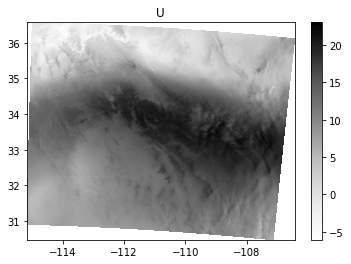

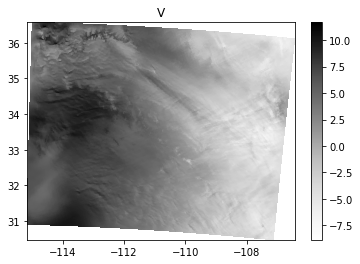

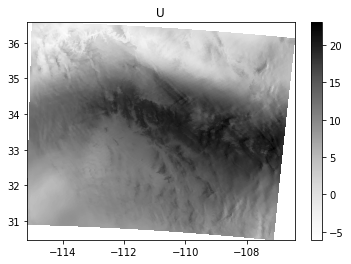

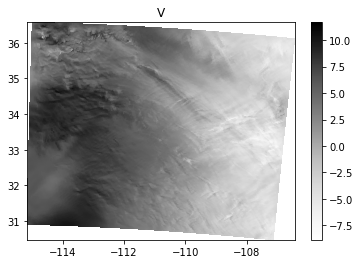

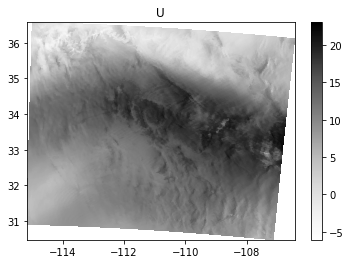

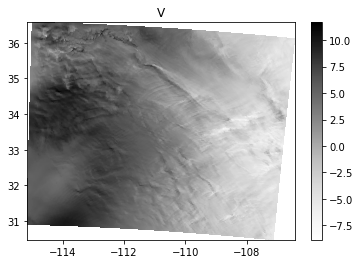

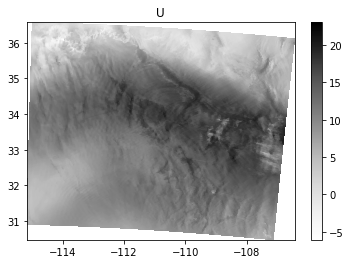

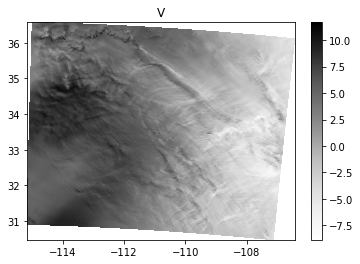

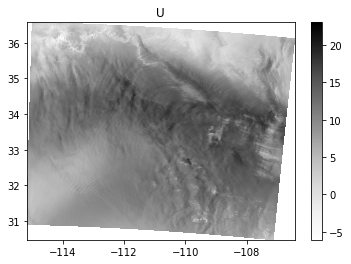

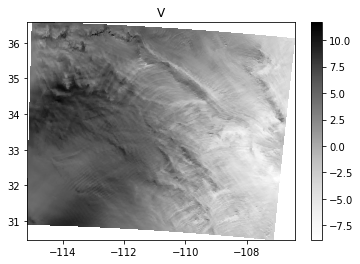

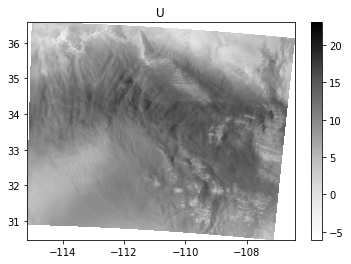

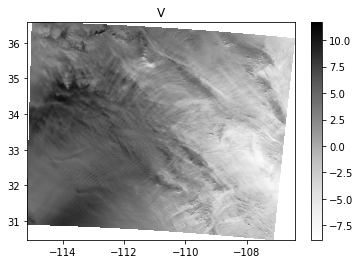

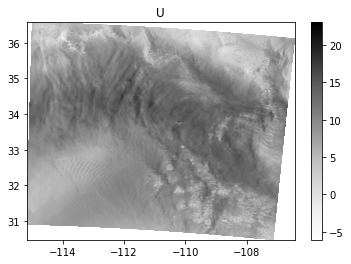

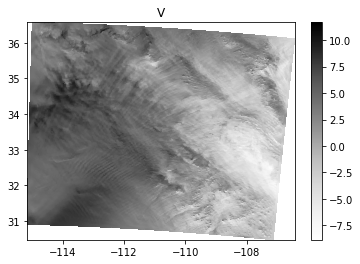

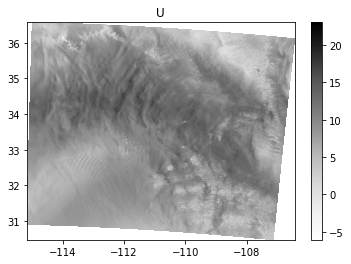

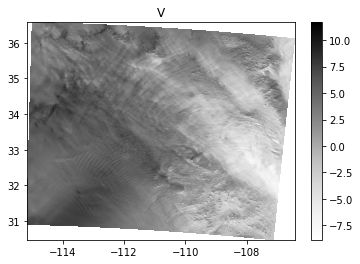

In [11]:
for t in range(U.index.size):
    vmin = U.values.min()
    vmax = U.values.max()
    plt.figure()
    im = plt.pcolormesh(
        wind_lons.reshape(U_shape[0], V_shape[1]),
        wind_lats.reshape(U_shape[0], V_shape[1]),
        U.iloc[t].values.reshape(U_shape)[:, 1:],
        cmap='Greys', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('U')
    
    vmin = V.values.min()
    vmax = V.values.max()
    plt.figure()
    im = plt.pcolormesh(
        wind_lons.reshape(U_shape[0], V_shape[1]),
        wind_lats.reshape(U_shape[0], V_shape[1]),
        V.iloc[t].values.reshape(V_shape)[1:, :],
        cmap='Greys', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('V')

In [8]:
## clear day
year = 2014
month = clear_month
day = clear_day
solar_noon = pd.Timestamp('12:30:00')
solar_noon = solar_noon.replace(year=year, month=month, day=day)
step = pd.Timedelta('3h')
start = solar_noon - step
start = (start - pd.Timedelta('7.5min')).round(freq='15min')
end = solar_noon + step
end = (end + pd.Timedelta('7.5min')).round(freq='15min')
clear_times = pd.date_range(start, end, freq='15min').tz_localize('MST')
print(clear_times)

DatetimeIndex(['2014-06-07 09:30:00-07:00', '2014-06-07 09:45:00-07:00',
               '2014-06-07 10:00:00-07:00', '2014-06-07 10:15:00-07:00',
               '2014-06-07 10:30:00-07:00', '2014-06-07 10:45:00-07:00',
               '2014-06-07 11:00:00-07:00', '2014-06-07 11:15:00-07:00',
               '2014-06-07 11:30:00-07:00', '2014-06-07 11:45:00-07:00',
               '2014-06-07 12:00:00-07:00', '2014-06-07 12:15:00-07:00',
               '2014-06-07 12:30:00-07:00', '2014-06-07 12:45:00-07:00',
               '2014-06-07 13:00:00-07:00', '2014-06-07 13:15:00-07:00',
               '2014-06-07 13:30:00-07:00', '2014-06-07 13:45:00-07:00',
               '2014-06-07 14:00:00-07:00', '2014-06-07 14:15:00-07:00',
               '2014-06-07 14:30:00-07:00', '2014-06-07 14:45:00-07:00',
               '2014-06-07 15:00:00-07:00', '2014-06-07 15:15:00-07:00',
               '2014-06-07 15:30:00-07:00'],
              dtype='datetime64[ns, MST]', freq='15T')


In [9]:
## cloudy day
year = 2014
month = cloudy_month
day = cloudy_day
solar_noon = pd.Timestamp('12:30:00')
solar_noon = solar_noon.replace(year=year, month=month, day=day)
step = pd.Timedelta('3h')
start = solar_noon - step
start = (start - pd.Timedelta('7.5min')).round(freq='15min')
end = solar_noon + step
end = (end + pd.Timedelta('7.5min')).round(freq='15min')
cloudy_times = pd.date_range(start, end, freq='15min').tz_localize('MST')
print(cloudy_times)

DatetimeIndex(['2014-06-12 09:30:00-07:00', '2014-06-12 09:45:00-07:00',
               '2014-06-12 10:00:00-07:00', '2014-06-12 10:15:00-07:00',
               '2014-06-12 10:30:00-07:00', '2014-06-12 10:45:00-07:00',
               '2014-06-12 11:00:00-07:00', '2014-06-12 11:15:00-07:00',
               '2014-06-12 11:30:00-07:00', '2014-06-12 11:45:00-07:00',
               '2014-06-12 12:00:00-07:00', '2014-06-12 12:15:00-07:00',
               '2014-06-12 12:30:00-07:00', '2014-06-12 12:45:00-07:00',
               '2014-06-12 13:00:00-07:00', '2014-06-12 13:15:00-07:00',
               '2014-06-12 13:30:00-07:00', '2014-06-12 13:45:00-07:00',
               '2014-06-12 14:00:00-07:00', '2014-06-12 14:15:00-07:00',
               '2014-06-12 14:30:00-07:00', '2014-06-12 14:45:00-07:00',
               '2014-06-12 15:00:00-07:00', '2014-06-12 15:15:00-07:00',
               '2014-06-12 15:30:00-07:00'],
              dtype='datetime64[ns, MST]', freq='15T')


In [22]:
importlib.reload(tmh_id)
save_path = './data/'
tmh_id.interp_sat(cloudy_times=cloudy_times,
                  clear_times=clear_times,
                  dx=.25, save_path=save_path)

./data/for_6_12/{var}


In [23]:
suffix = '_' + str(cloudy_month) + '_' + str(cloudy_day)
load_path = './data/for' + suffix + '/' + '{var}'
csi = pd.read_hdf(load_path.format(var='csi.h5'))
shape = np.load(load_path.format(var='domain_shape.npy'))
x = np.load(load_path.format(var='x.npy'))
y = np.load(load_path.format(var='y.npy'))

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


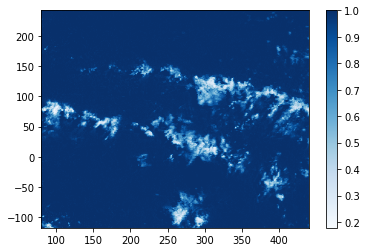

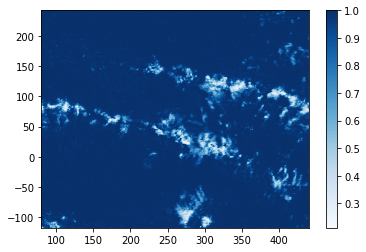

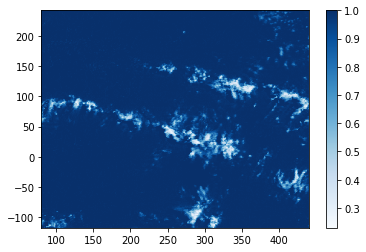

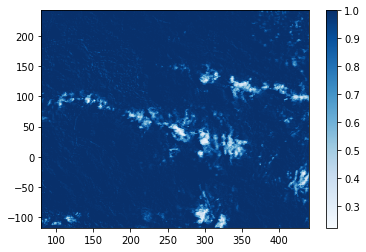

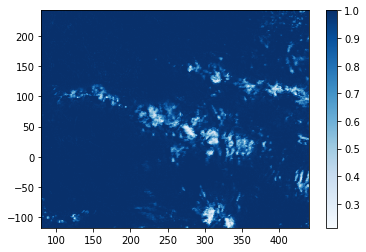

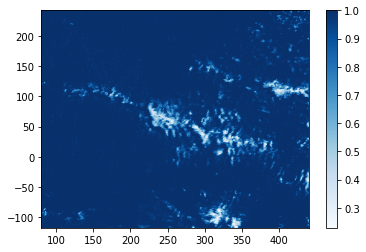

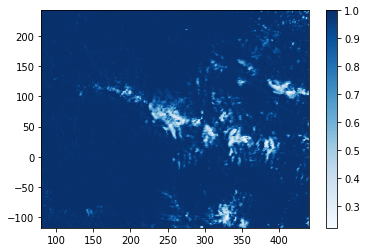

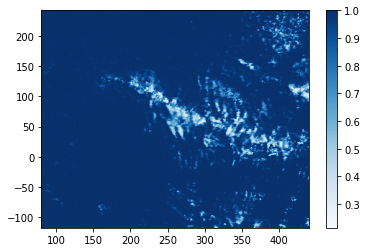

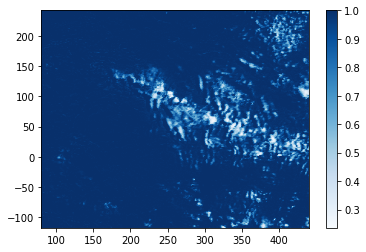

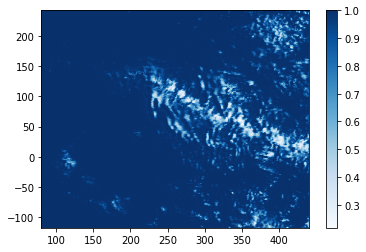

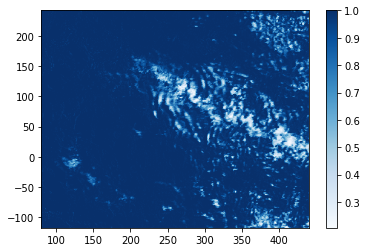

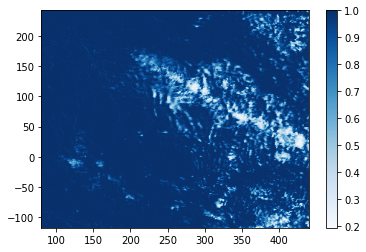

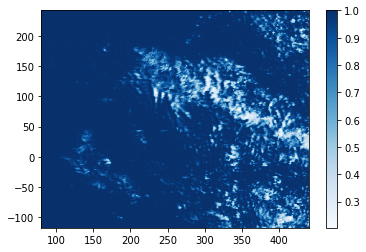

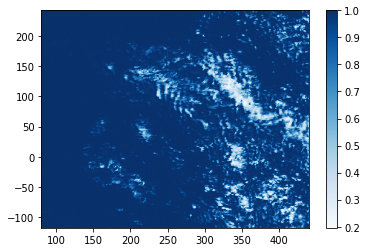

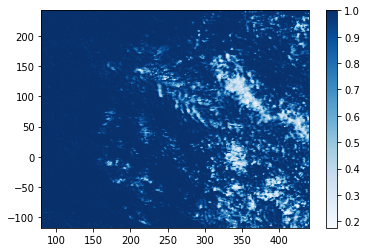

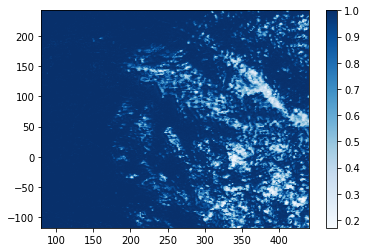

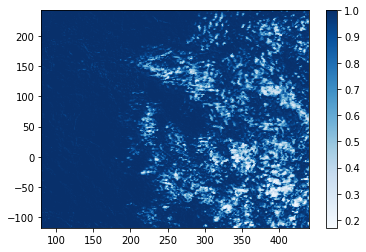

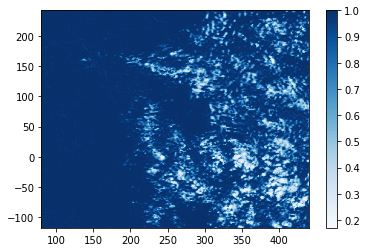

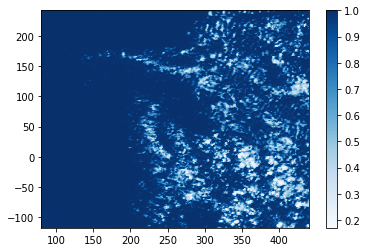

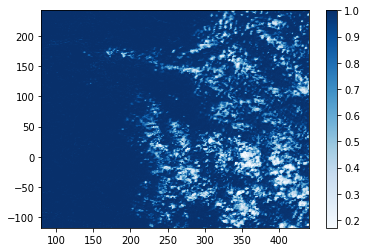

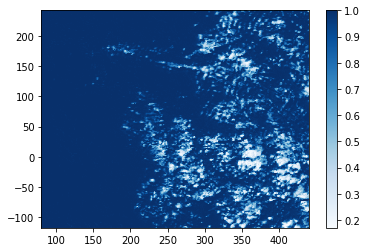

In [25]:
vmin=None
vmax=None
for t in np.arange(csi.index.size): #np.arange(5) + 10:
    plt.figure()
    im = plt.pcolormesh(x, y, csi.iloc[t].reshape(shape),
                        cmap='Blues',
                        vmin=vmin, vmax=vmax)
    plt.colorbar(im)

In [26]:
importlib.reload(tmh_id)
save_path='./data/'
date = cloudy_times[0]
tmh_id.interp_wind(save_path=save_path, date=date)

In [ ]:
suffix = '_' + str(cloudy_month) + '_' + str(cloudy_day)
load_path = './data/for' + suffix + '/' + '{var}'
U = pd.read_hdf(load_path.format(var='U.h5'))
U_shape = np.load(load_path.format(var='U_shape.npy'))
x = np.load(load_path.format(var='x.npy'))
y = np.load(load_path.format(var='y.npy'))

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


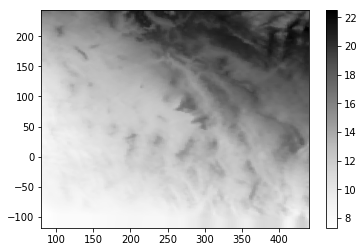

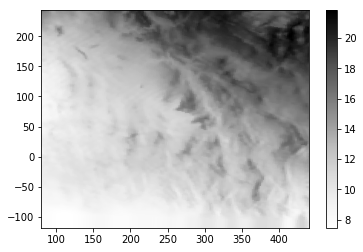

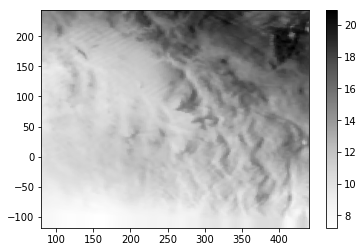

In [ ]:
for t in np.arange(5):
    plt.figure()
    im = plt.pcolormesh(x, y, U.iloc[t].reshape(U_shape)[:, 1:], cmap='Greys')
    plt.colorbar(im)